# **Evaluate Synthetic Data**
Once we generate our synthetic data, the next crucial step is to **assess its quality and relevance** to ensure it mirrors the complexities of human data.
### Objectives:
- **Quality Control:** Verify that synthetic questions and labels are high quality.
- **Data Analysis:** 
  - Explore the distribution of questions by domain, length, and complexity.
  - Use scatter plots of embeddings and frequency analysis (comparing baseline, golden, and industry-specific data).
### Key Considerations:
- **Filtering:** Identify and remove duplicates or outliers.
- **Comparative Analysis:** Ensure the synthetic data covers a wide range of scenarios and closely resembles true human distributions.
This evaluation confirms that our synthetic data is robust enough to serve as a stand-in for human-generated data in downstream evaluation tasks.

In [1]:
import json
import requests
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

import textstat
from sklearn.metrics.pairwise import cosine_similarity
from nltk.translate.bleu_score import sentence_bleu

import nltk
from collections import Counter
from nltk.corpus import reuters, brown

nltk.download('punkt')
nltk.download('reuters')
nltk.download('brown')

plt.style.use('ggplot')
sns.set_context("talk")  # Increase font sizes

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\povelf\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package reuters to
[nltk_data]     C:\Users\povelf\AppData\Roaming\nltk_data...
[nltk_data]   Package reuters is already up-to-date!
[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\povelf\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!


## **Read data**

In [2]:
path='data/ft-judge/single/chunk-specific-synthetic-questions.jsonl'
with open(path, 'r') as f:
    data = [json.loads(line) for line in f if line.strip()]

In [9]:
# Flatten the data using json_normalize
df = pd.json_normalize(data)
df = df.drop(columns=['question_number'])

df.shape

(30, 13)

## **Analysis**

In [4]:
df_analysis = pd.DataFrame()

### **Linguistic and Stylistic Quality**
#### Flesch Reading Ease Score

The **Flesch Reading Ease (FRE) Score** is a readability metric that measures how easy a text is to read. It is calculated using the formula:

$$ 
FRE = 206.835 - (1.015 \times \frac{\text{Total Words}}{\text{Total Sentences}}) - (84.6 \times \frac{\text{Total Syllables}}{\text{Total Words}})
$$

#### Interpretation:
- **90–100** → Very Easy (5th grade level)
- **60–70** → Standard (8th-9th grade level)
- **30–50** → Difficult (College level)
- **0–30** → Very Difficult (Professional/Academic level)

A **higher score** means the text is **easier to read**.

🔹 *Use Case:* Helps assess readability in education, content writing, SEO, and technical documents.


In [5]:
# Calculate the Flesch Reading Ease score for each synthetic question.
df['flesch_reading_ease_q'] = df['synthetic_question'].apply(lambda x: textstat.flesch_reading_ease(x))
df['flesch_reading_ease_q'].head()

0    84.68
1    45.42
2    78.25
3    36.96
4    89.75
Name: flesch_reading_ease_q, dtype: float64

In [6]:
# Calculate the Flesch Reading Ease score for each synthetic question.
df['flesch_reading_ease_r'] = df['synthetic_response'].apply(lambda x: textstat.flesch_reading_ease(x))
df['flesch_reading_ease_r'].head()

0    79.26
1    38.15
2    34.93
3    32.73
4    76.56
Name: flesch_reading_ease_r, dtype: float64

### **Exploring Question Distributions**
To understand the dataset, we visualize the distribution of questions by **Domain, Difficulty, and Tone** using bar charts.

- **Domain:** Number of questions per subject area.
- **Difficulty:** Spread across difficulty levels.
- **Tone:** Frequency of different tones.

🔹 *Use Case:* Detects biases, gaps, or imbalances in the dataset.


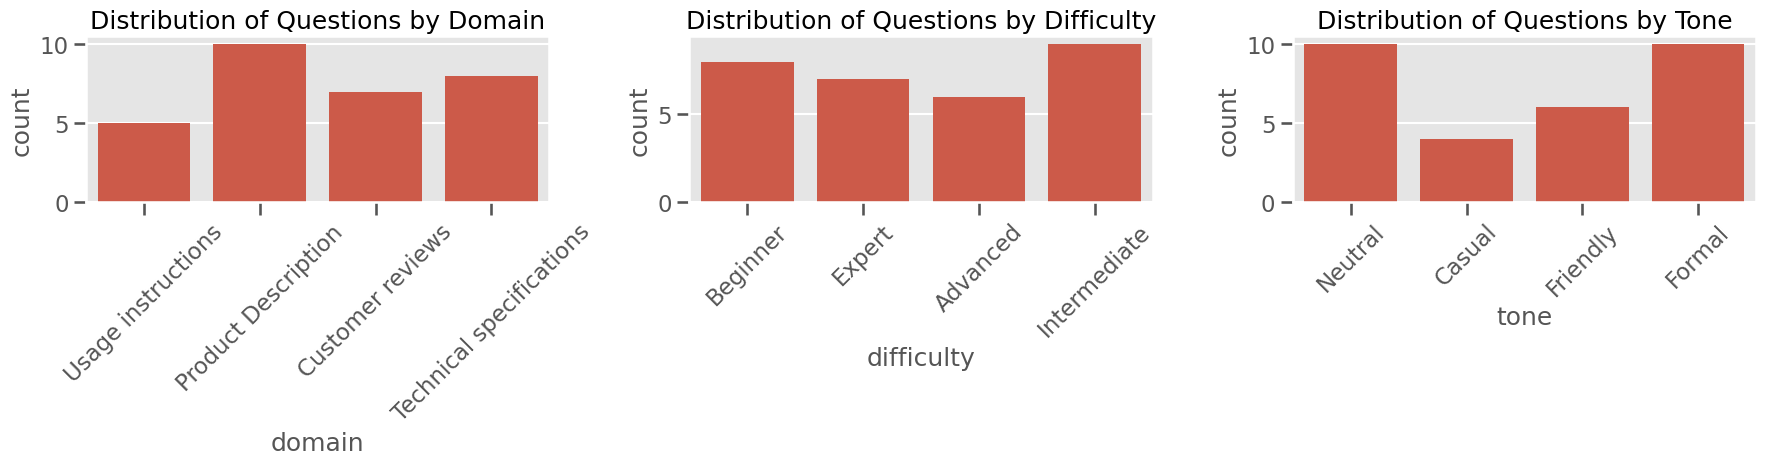

In [7]:
# Create a figure with 3 subplots (1 row, 3 columns)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # Adjust figure size as needed

# Plot 1: Distribution by Domain
sns.countplot(data=df, x='domain', ax=axes[0])
axes[0].set_title("Distribution of Questions by Domain")
axes[0].tick_params(axis='x', rotation=45)  # Rotate x-axis labels

# Plot 2: Distribution by Difficulty
sns.countplot(data=df, x='difficulty', ax=axes[1])
axes[1].set_title("Distribution of Questions by Difficulty")
axes[1].tick_params(axis='x', rotation=45)  # Rotate x-axis labels

# Plot 3: Distribution by Tone
sns.countplot(data=df, x='tone', ax=axes[2])
axes[2].set_title("Distribution of Questions by Tone")
axes[2].tick_params(axis='x', rotation=45)  # Rotate x-axis labels

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


### **t-SNE Clustering of Question Embeddings**
To visualize **high-dimensional embeddings**, we apply **t-SNE** for dimensionality reduction.

4. **Visualize as a scatter plot**, colored by **domain**.

🔹 *Use Case:* Reveals clusters, patterns, and potential outliers in the dataset.

THe hyper parameter 

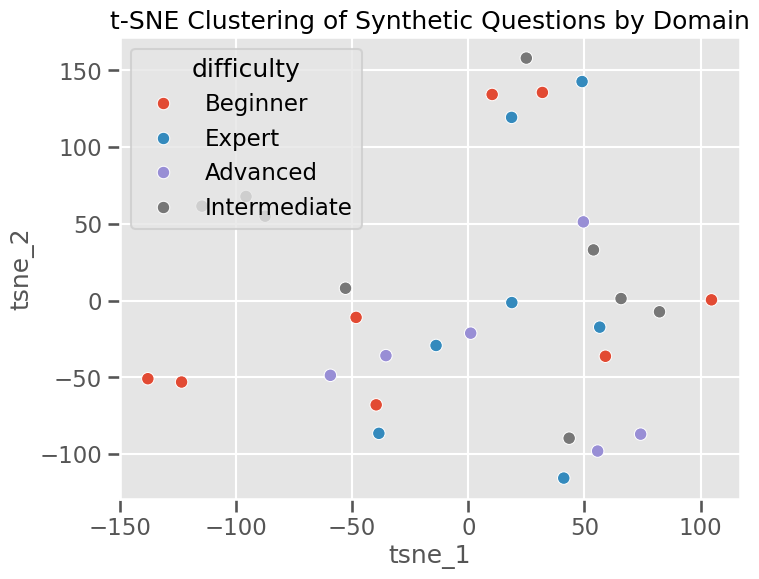

In [12]:
synthetic_embeddings = [np.array(df['synthetic_embedding'][i], dtype=np.float32).reshape(-1,1) 
                        for i in range(len(df['synthetic_embedding']))]

synthetic_embeddings_array = np.vstack([emb.T for emb in synthetic_embeddings])  # Shape: (num_samples, embedding_dim)

# Run t-SNE to reduce to 2 dimensions.
# Note on perplexity:
# - Perplexity is a parameter that balances the focus between local and global structure in the data.
# - For a dataset with thousands of samples, a value around 30 is common.
# - However, for quick test runs with only a few samples, we must use a lower value (e.g., 5) to avoid errors,
#   as perplexity must be less than the number of samples.
tsne = TSNE(n_components=2, random_state=42, perplexity=5)
tsne_results = tsne.fit_transform(synthetic_embeddings_array)

# Add t-SNE results to the DataFrame.
df_analysis['tsne_1'] = tsne_results[:, 0]
df_analysis['tsne_2'] = tsne_results[:, 1]

df_analysis['label'] = df['is_grounded']
df_analysis['difficulty'] = df['difficulty']

# Visualize, coloring points by 'difficulty'
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_analysis, x='tsne_1', y='tsne_2', hue='difficulty')
plt.title("t-SNE Clustering of Synthetic Questions by Domain")
plt.show()


### **Comparative Distribution Analysis**

This analysis examines the length of **synthetic** and **golden** questions, visualizing distributions and assessing their correlation with readability.

#### **How It Works**
- **Word Count Calculation**: Tokenizes and counts words in both question types.
- **Distribution Visualization**: Plots histograms to compare question lengths.
- **Readability Correlation**: Computes correlation between synthetic question length and **Flesch Reading Ease**.

#### **Key Insights**
- Do synthetic questions tend to be **longer or shorter** than golden ones?
- How does length impact **readability** and **comprehension**?

In [13]:
def get_question_length(mu=2.4, sigma=0.42, min_length=4):
    # Sample a question length from a log-normal distribution.
    length = int(np.round(np.random.lognormal(mean=mu, sigma=sigma)))
    return max(min_length, length)

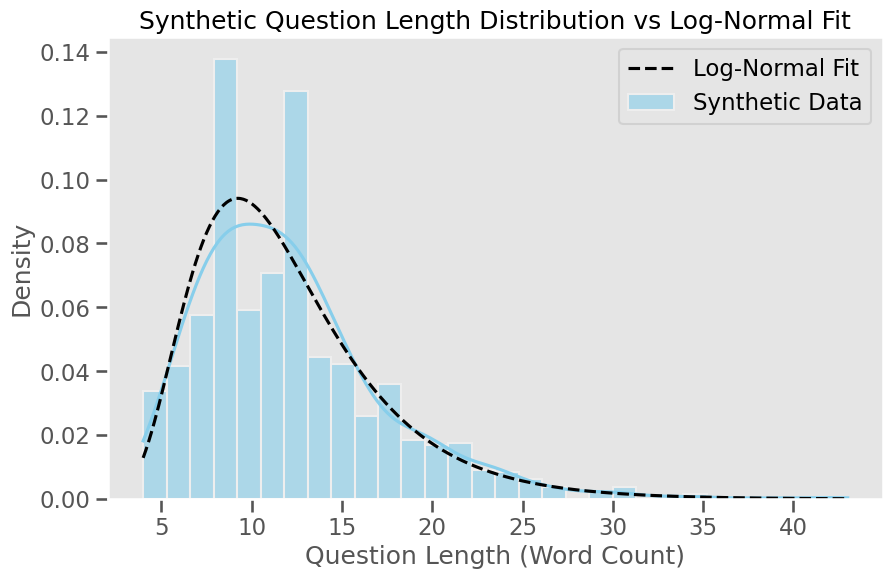

In [14]:
def plot_golden_and_synthetic_distributions(mu=2.4, sigma=0.42, min_length=4):
    # Generate synthetic question lengths based on the computed mu and sigma
    synthetic_lengths = [max(min_length, int(np.round(np.random.lognormal(mu, sigma)))) for _ in range(1000)]

    # Plot the golden data distribution
    plt.figure(figsize=(10, 6))
    # sns.histplot(golden_lengths, bins=30, kde=True, color="salmon", label="Golden Data", stat="density", alpha=0.6)
    sns.histplot(synthetic_lengths, bins=30, kde=True, color="skyblue", label="Synthetic Data", stat="density", alpha=0.6)

    # Overlay the theoretical log-normal distribution
    x = np.linspace(min(synthetic_lengths), max(synthetic_lengths), 500)
    pdf = (1 / (x * sigma * np.sqrt(2 * np.pi))) * np.exp(-((np.log(x) - mu)**2) / (2 * sigma**2))
    plt.plot(x, pdf, color="black", linestyle="--", label="Log-Normal Fit")

    # Add labels and legend
    plt.title("Synthetic Question Length Distribution vs Log-Normal Fit")
    plt.xlabel("Question Length (Word Count)")
    plt.ylabel("Density")
    plt.legend()
    plt.grid()
    plt.show()


plot_golden_and_synthetic_distributions()

### **Token Frequency Analysis**

This analysis compares the most frequent tokens appearing in **synthetic** and compares it against their frequency in:
- The **Brown** corpus.
- The **SQuAD** corpus.

#### **How It Works**
- **Tokenization & Preprocessing**: Converts text to lowercase and tokenizes words.
- **Frequency Computation**: Computes normalized token frequency (dividing each count by the total token count).
- **Comparison**:
  - The top 20 most frequent words in **synthetic questions** are extracted.
  - Their frequencies are compared against their frequency in **golden queries**.

#### **Key Insights**
- What are the **most common** words in synthetic vs. other corpuses?
- Do synthetic questions use a **more repetitive vocabulary**?


In [15]:
# Function to compute normalized token frequency from a text dataset
def get_normalized_token_frequency(text_series):
    tokens = []
    for text in text_series:
        tokens.extend(nltk.word_tokenize(text.lower()))  # Tokenization and lowercasing
    
    token_counts = Counter(tokens)
    total_tokens = sum(token_counts.values())  # Total token count
    
    return {token: count / total_tokens for token, count in token_counts.items()}  # Normalize

In [16]:
# Function to compute normalized token frequency from an NLTK corpus
def compute_token_frequency(corpus_words):
    tokens = [token.lower() for token in corpus_words]
    token_counts = Counter(tokens)
    total_tokens = sum(token_counts.values())
    return {token: count / total_tokens for token, count in token_counts.items()}  # Normalize

In [17]:
# Load and process a question-based dataset (SQuAD)
def load_squad_questions():
    squad_url = "https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json"
    response = requests.get(squad_url)
    squad_data = response.json()
    questions = []
    
    for article in squad_data['data']:
        for paragraph in article['paragraphs']:
            for qa in paragraph['qas']:
                questions.extend(nltk.word_tokenize(qa['question'].lower()))  # Tokenize questions

    return questions

In [18]:
# Compute normalized token frequency for synthetic and golden questions.
synthetic_freq_q = get_normalized_token_frequency(df['synthetic_question'])
synthetic_freq_r = get_normalized_token_frequency(df['synthetic_response'])

# Load and process Reuters Corpus
reuters_words = reuters.words()
reuters_freq = compute_token_frequency(reuters_words)

# Load and process Brown Corpus
brown_words = brown.words()
brown_freq = compute_token_frequency(brown_words)

# Load and process SQuAD questions (question based dataset)
squad_words = load_squad_questions()
squad_freq = compute_token_frequency(squad_words)

In [19]:
# Extract top 20 normalized tokens for each dataset
synthetic_top_q = sorted(synthetic_freq_q.items(), key=lambda x: x[1], reverse=True)[:20]
synthetic_top_r = sorted(synthetic_freq_r.items(), key=lambda x: x[1], reverse=True)[:20]

brown_top = sorted(brown_freq.items(), key=lambda x: x[1], reverse=True)[:20]
squad_top = sorted(squad_freq.items(), key=lambda x: x[1], reverse=True)[:20]

# Unpack tokens and counts
tokens_synth_q, counts_synth_q = zip(*synthetic_top_q)
tokens_synth_r, counts_synth_r = zip(*synthetic_top_r)
tokens_brown, counts_brown = zip(*brown_top)
tokens_squad, counts_squad = zip(*squad_top)

In [20]:
# Function to plot token frequency comparison
def plot_token_frequency_comparison(tokens1, counts1, tokens2, counts2, label1, label2, title):
    x = range(len(tokens1))
    plt.figure(figsize=(12, 6))
    plt.bar(x, counts1, width=0.4, label=label1, alpha=0.7)
    plt.bar([i + 0.4 for i in x], counts2, width=0.4, label=label2, alpha=0.7)
    plt.xticks([i + 0.2 for i in x], tokens1, rotation=45)
    plt.xlabel("Tokens")
    plt.ylabel("Normalized Frequency")
    plt.title(title)
    plt.legend()
    plt.show()

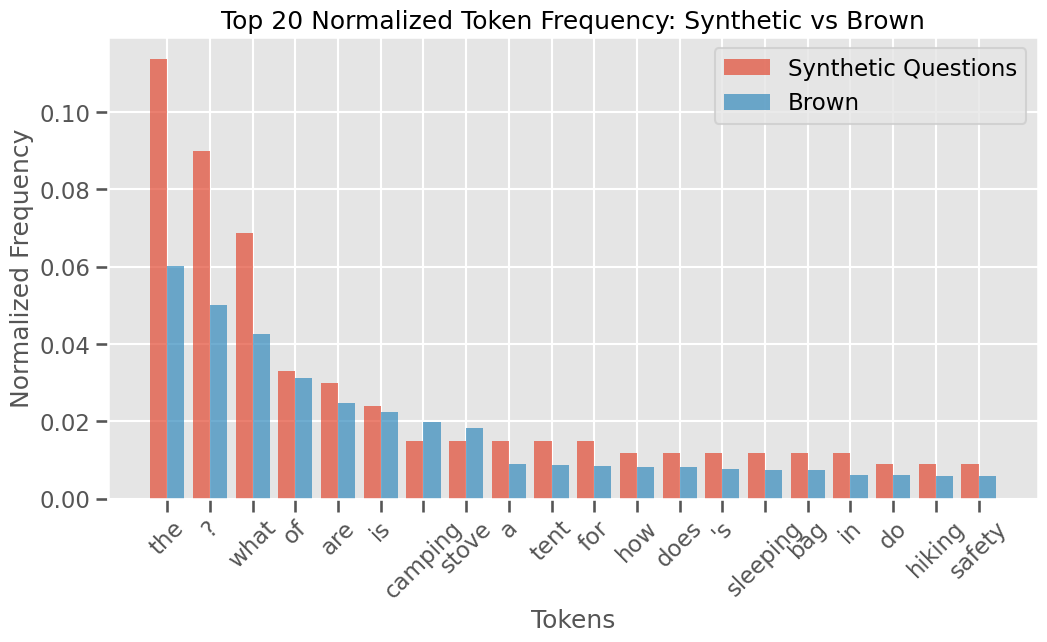

In [21]:
# Plot 2: Synthetic vs Brown
plot_token_frequency_comparison(tokens_synth_q, counts_synth_q, tokens_brown, counts_brown, 
                                "Synthetic Questions", "Brown", "Top 20 Normalized Token Frequency: Synthetic vs Brown")


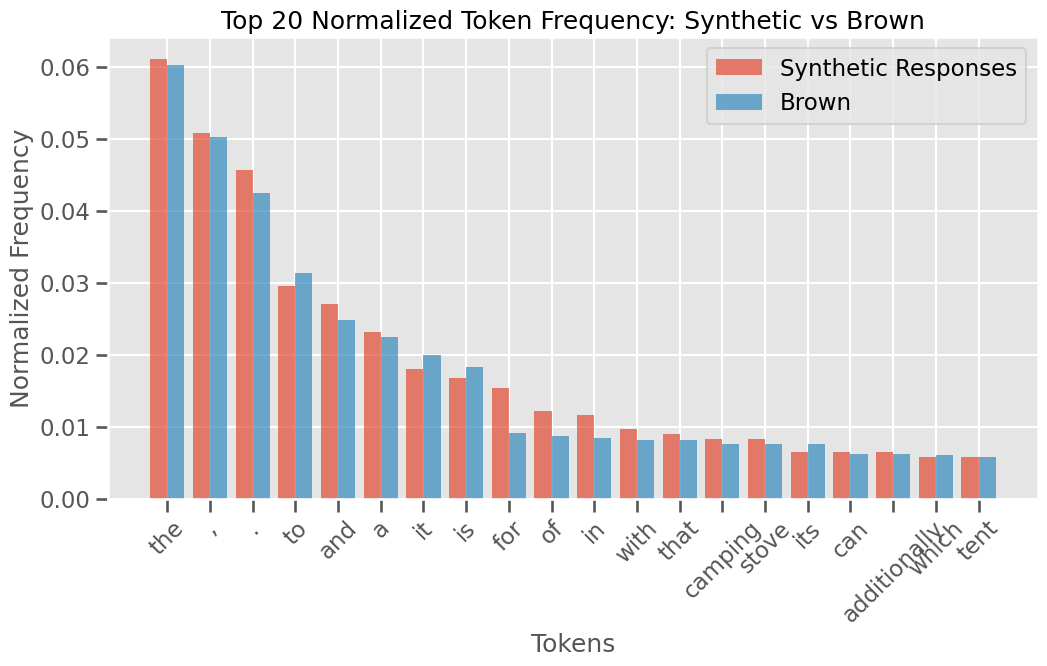

In [22]:
# Plot 2: Synthetic vs Brown
plot_token_frequency_comparison(tokens_synth_r, counts_synth_r, tokens_brown, counts_brown, 
                                "Synthetic Responses", "Brown", "Top 20 Normalized Token Frequency: Synthetic vs Brown")

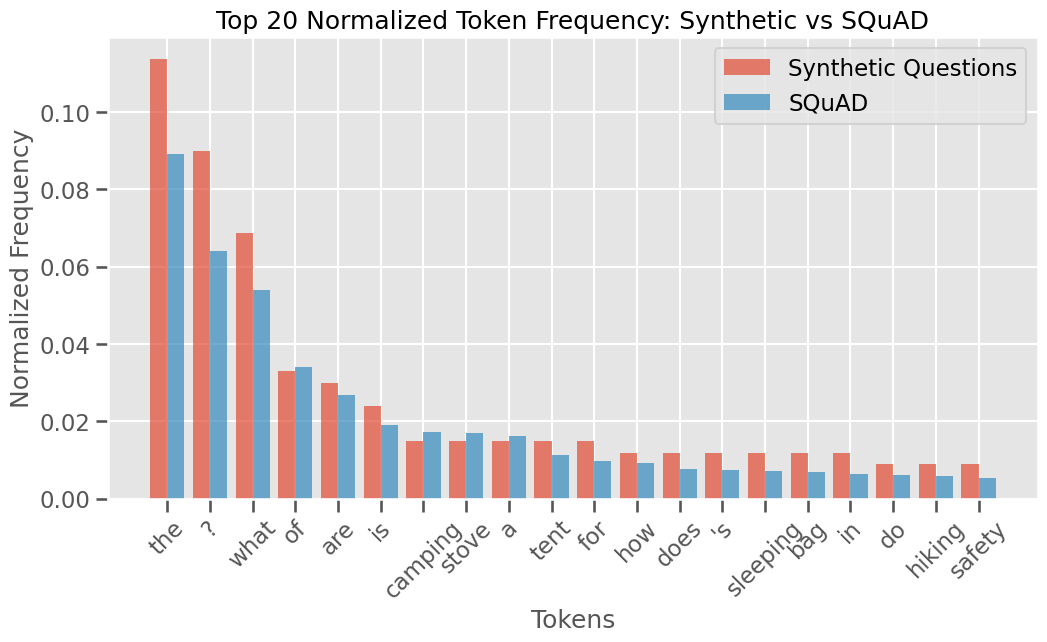

In [23]:
# Plot 3: Synthetic vs SQuAD
plot_token_frequency_comparison(tokens_synth_q, counts_synth_q, tokens_squad, counts_squad, 
                                "Synthetic Questions", "SQuAD", "Top 20 Normalized Token Frequency: Synthetic vs SQuAD")